In [1]:
import optuna as opt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

import sys
sys.path.append('../../pscapes')
sys.path.append('../../nk-ml-2024')

from torch.utils.data import DataLoader

from pscapes.landscape_class import ProteinLandscape
from pscapes.utils import dict_to_np_array, np_array_to_dict

from src.architectures import SequenceRegressionCNN, SequenceRegressionLSTM, SequenceRegressionMLP, SequenceRegressionLinear, SequenceRegressionTransformer
from src.ml_utils import train_val_test_split_ohe, train_model
import pickle

from sklearn.metrics import r2_score




/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
HPARAM_PATH = 'results/NK_hyperopt_results.pkl'
DATAPATH = '../data/nk_landscapes/'

In [4]:
# read hyperopt results 
with open('results/NK_hyperopt_results.pkl', 'rb') as handle:
    NK_studies = pickle.load(handle)


In [5]:
NK_studies['linear']

In [6]:
SEQ_LEN = 6
AA_ALPHABET = 'ACDEFG'

In [7]:
LANDSCAPES = []
for k in range(6): 
    for r in range(1): 
        landscape = ProteinLandscape(csv_path='../data/nk_landscapes/k{0}_r{1}.csv'.format(k,r), amino_acids=AA_ALPHABET)
        LANDSCAPES.append(landscape)

LANDSCAPES = [i.fit_OHE() for i in LANDSCAPES]

landscapes_ohe, xy_train, xy_val, xy_test, x_tests, y_tests = train_val_test_split_ohe(LANDSCAPES)

In [ ]:
def read_CNN_hparams(study): 
    num_conv_layers = params['num_conv_layers']
    n_kernels       = [params['n_kernels_layer{}'.format(i)] for i in range(num_conv_layers)]
    kernel_sizes    = [params['kernel_size_layer{}'.format(i)] for i in range(num_conv_layers)]

    param_dict = {'num_conv_layers':num_conv_layers, 'n_kernels': n_kernels, 'kernel_sizes':kernel_sizes}
    return param_dict

def read_MLP_hparams(study): 



def train_from_hparams(study, xy_train, xy_val, xy_test):
    """
    Trains and evaluates a model from hparams of an optuna study. 
    
    Args: 
        study (optuna.study):             optuna study object 
        xy_train ():                      xy_train data
        xy_val():                         xy_val data 
        xy_test():                        xy_val data 
    Returns: 
        trained_model
    """
    
    
    

In [35]:

#loop over K values 
train_epoch_losses_list = []
val_epoch_losses_list   = []
r2_scores               = []
predict_vs_gt           = []

for index,i in enumerate(cnn_studies):
    print('Training model for K={}'.format(index))

    #initialise models with correct parameters from hyperopt
    params          = i.best_params
    num_conv_layers = params['num_conv_layers']
    n_kernels       = [params['n_kernels_layer{}'.format(i)] for i in range(num_conv_layers)]
    kernel_sizes    = [params['kernel_size_layer{}'.format(i)] for i in range(num_conv_layers)]
    lr              = params['lr']
    batch_size      = params['batch_size']

    device = 'cuda' if torch.cuda.is_available else 'cpu'

    model     = SequenceRegressionCNN(input_channels=len(AA_ALPHABET), sequence_length=SEQ_LEN,
                                 num_conv_layers=num_conv_layers, n_kernels=n_kernels, kernel_sizes=kernel_sizes)
    loss_fn   = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    #load dataloaders
    train_dataloader = DataLoader(xy_train[index], batch_size=batch_size, shuffle=True)
    val_dataloader   = DataLoader(xy_val[index], batch_size=batch_size)


    #train models
    model, train_epoch_losses, val_epoch_losses = train_model(model, optimizer, loss_fn, train_dataloader, val_dataloader, 
                                                                         n_epochs=40, device=device, patience=8, min_delta=1e-5)
    
    train_epoch_losses_list.append(train_epoch_losses)
    val_epoch_losses_list.append(val_epoch_losses)

    #save the model
    savepath = './models_test/CNN_K{}.pt'.format(index)
    torch.save(model.state_dict(), savepath)

    #evaluate model on test data
    model.eval()

    y_pred  = model(x_tests[index].to(device))
    y_pred  = y_pred.cpu().detach()
    y_test  = y_tests[index].detach()


    r2      = r2_score(y_pred, y_test) 

    r2_scores.append(r2)

    predict_vs_gt.append([y_pred, y_test])
    

losses = [train_epoch_losses_list, val_epoch_losses_list, r2_scores]


with open('CNN_models_epoch_losses_r2.pkl', 'wb') as handle:
    pickle.dump(losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('CNN_models_predict_vs_gt.pkl', 'wb') as handle:
    pickle.dump(predict_vs_gt, handle, protocol=pickle.HIGHEST_PROTOCOL)


print('All models trained and saved.')


Training model for K=0
Epoch [1/40], Train Loss: 4.4721, Val Loss: 0.0001
Epoch [2/40], Train Loss: 0.0595, Val Loss: 0.0001
Epoch [3/40], Train Loss: 0.0756, Val Loss: 0.0002
Epoch [4/40], Train Loss: 0.0939, Val Loss: 0.0001
Epoch [5/40], Train Loss: 0.0789, Val Loss: 0.0001
Epoch [6/40], Train Loss: 0.0924, Val Loss: 0.0000
Epoch [7/40], Train Loss: 0.0598, Val Loss: 0.0001
Epoch [8/40], Train Loss: 0.0267, Val Loss: 0.0000
Epoch [9/40], Train Loss: 0.0410, Val Loss: 0.0001
Epoch [10/40], Train Loss: 0.0358, Val Loss: 0.0001
Epoch [11/40], Train Loss: 0.0173, Val Loss: 0.0000
Epoch [12/40], Train Loss: 0.0207, Val Loss: 0.0001
Epoch [13/40], Train Loss: 0.0180, Val Loss: 0.0000
Epoch [14/40], Train Loss: 0.0182, Val Loss: 0.0000
Epoch [15/40], Train Loss: 0.0183, Val Loss: 0.0000
Epoch [16/40], Train Loss: 0.0128, Val Loss: 0.0000
Early stopping triggered
Training model for K=1
Epoch [1/40], Train Loss: 7.7658, Val Loss: 0.0021
Epoch [2/40], Train Loss: 1.2162, Val Loss: 0.0010
Epoc

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
NK_studies['cnn'][4].best_params

{'lr': 0.01,
 'batch_size': 128,
 'num_conv_layers': 2,
 'n_kernels_layer0': 128.0,
 'n_kernels_layer1': 224.0,
 'kernel_size_layer0': 5.0,
 'kernel_size_layer1': 3.0}

In [19]:
train_models_from_hparams_NK( hparams_path=HPARAM_PATH, datapath=DATAPATH, model_savepath=None, result_path=None, 
                             amino_acids=AA_ALPHABET, seq_length=SEQ_LEN,
                                 n_replicates=8, n_epochs=30, patience=5, min_delta=1e-5)

Loading landscapes.
Calculating train-test-val splits


KeyError: 'learning_rate'

In [15]:

def read_CNN_hparams(best_params): 
    params = best_params
    num_conv_layers = params['num_conv_layers']
    n_kernels       = [params['n_kernels_layer{}'.format(i)] for i in range(num_conv_layers)]
    kernel_sizes    = [params['kernel_size_layer{}'.format(i)] for i in range(num_conv_layers)]

    param_dict = {'num_conv_layers':num_conv_layers, 'n_kernels': n_kernels, 'kernel_sizes':kernel_sizes}
    return param_dict

def read_MLP_hparams(best_params): 
    params=best_params
    n_hidden_layers = params['n_hidden_layers']    
    hidden_sizes = [params['hidden{}_size'.format(i)] for i in range(n_hidden_layers)]
    param_dict  = {'hidden_sizes': hidden_sizes}
    return param_dict

def read_LSTM_hparams(best_params): 
    params = best_params
    num_layers  = params['num_layers']
    hidden_size = params['hidden_size']
    param_dict = {'num_layers': num_layers, 'hidden_size': hidden_size}
    return param_dict
def read_transformer_hparams(best_params): 
    params = best_params
    d_model = params['embed_dim_num_heads'][0]
    nheads  = params['embed_dim_num_heads'][1]
    num_layers = params['num_layers']
    dim_feedforward = params['dim_feedforward']
    max_seq_length = params['max_seq_length']
    param_dict = {'d_model': d_model, 'nhead': nheads, 'num_layers':num_layers,'dim_feedforward':dim_feedforward, 
                 'max_seq_length': max_seq_length}
    return param_dict
    
    
def train_models_from_hparams_NK(hparams_path, datapath, model_savepath, result_path, amino_acids, seq_length, 
                                 n_replicates, n_epochs=30, patience=5, min_delta=1e-5):
    """
    Performs training of a given model with a given set of hyperparameters against NK landscapes replicates.

    model (architectures.py object): model to train. Do not instantiate model with model() before passing. 
    
    hparams_path (str):              path to pickled list of optuna studies containing results of hyperparameter 
                                     optimisation, with each list element containing the optuna study for the k-th NK landscape
    datapath (str):                  path to csv files of nk landscapes, formatted as k{}_r{}.csv
    amino_acids (str):               alphabet of amino acids used to create NK landscapes 
    seq_length (int):                length of sequences in NK landscapes 
    n_replicates (int):              number of replicate NK landscapes to load for each K value
    
    """
    

    with open(hparams_path, 'rb') as handle:
        hparam_studies = pickle.load(handle)

    

        
    landscapes = []
    print('Loading landscapes.')
    for k in range(seq_length):
        replicate_list = []
        for r in range(n_replicates):
            landscape = ProteinLandscape(csv_path=datapath+'/k{0}_r{1}.csv'.format(k,r), amino_acids=amino_acids)
            replicate_list.append(landscape)
        landscapes.append(replicate_list)
    landscapes = [[i.fit_OHE() for i in j] for j in landscapes]

    print('Calculating train-test-val splits')
    splits = [train_val_test_split_ohe(i, random_state=1) for i in landscapes] #this will split each landscape replicate in each K 
                                                               #sublist into train-test-val splits
    
    #initialise some lists to collect results
    train_epoch_losses_list = []
    val_epoch_losses_list   = []
    r2_scores               = []
    predict_vs_gt           = []


    device = 'cuda' if torch.cuda.is_available else 'cpu'

    
    #loop over models 
    for model_name in hparam_studies.keys(): 
        studies  = hparam_studies[model_name]
        assert len(landscapes) == len(studies), 'Number of K values does not match number of hyper-parameter studies.'

        for k_index, k_value in enumerate(studies): 
            study  = studies[k_index]
            params = study.best_params

            #extract model agnostic hparams. These don't apply to sklearn models 
            if model_name!='RF' or model_name!='GB':             
                lr              = params['lr']
                batch_size      = params['batch_size']

            #extract model hparams 
            if model_name == 'linear':
                model_params = {'alphabet_size': len(amino_acids), 'sequence_length':seq_length}
            elif model_name == 'mlp':
                model_params = read_MLP_hparams(params) 
                model_params['alphabet_size']= len(amino_acids)
                model_params['sequence_length']=seq_length
            elif model_name == 'cnn': 
                model_params = read_CNN_hparams(params)
                model_params['input_channels'] = len(amino_acids)
                model_params['sequence_length']=seq_length
            elif model_name == 'ulstm': 
                model_params = read_LSTM_hparams(params)
                model_params['input_size'] = len(amino_acids)
                model_params['bidirectional'] = False 
            elif model_name == 'blstm': 
                model_params = read_LSTM_hparams(params)
                model_params['input_size'] = len(amino_acids)
                model_params['bidirectional'] = True 
            elif model_name == 'transformer': 
                model_params = read_transformer_hparams(params)
                model_params['input_dim']=len(amino_acids)
            elif (model_name == 'RF') or (model_name == 'GB') :
                model_params=params

            print('model name: {}, model_params: {}'.format(model_name, model_params))
"""        

                

            
        
    
    
    
    for k_val, k_replicates in enumerate(landscapes): 
        print('Training models for K={}'.format(k_val))
        #initialise correct hyperparameters
        params          = hparam_studies[k_val].best_params

        print('Models for this value of K will have the following hyperparameters:{}'.format(params))
        #extract hparams not passed to model 
        lr              = params['lr']
        batch_size      = params['batch_size']

        #extract hparams passed to model 
        if model==SequenceRegressionCNN: #here SequenceRegressionCNN is hardcoded
            model_params = read_CNN_hparams(params) #we need this special function to correctly parse hparams as stored in optuna study to those we can pass to our CNN model
            model_params['input_channels']=len(amino_acids)
            model_params['sequence_length']=seq_length
            model_name = 'CNN'
        else: 
            break #placeholder while developing

        #access appropriate data. Note that splits is structured as 
        #[[K1_repl1, ...K1_repli], ..., [Kj_repl1, ..., Kj_repli]].
        #Therefore, xy_train etc will be a list where each element contains data for a replicate landscape
        #such that xy_train = [repl1, repl2, ..., repli]
        landscapes_ohe, xy_train, xy_val, xy_test, x_tests, y_tests = splits[k_val]  

        train_epoch_losses_list_k = []
        val_epoch_losses_list_k   = []
        r2_scores_k               = []
        predict_vs_gt_k           = []
        
        #now loop over replicates at a given K value
        for r_index, replicate in enumerate(k_replicates):          

            print('Training model K= {}, replicate {}'.format(k_val, r_index))
            #define model, loss fn and optimiser 
            modelr     = model(**model_params)
            loss_fn   = nn.MSELoss()
            optimizer = optim.Adam(modelr.parameters(), lr=lr)

            
            
             #load dataloaders
            train_dataloader = DataLoader(xy_train[r_index], batch_size=batch_size, shuffle=True)
            val_dataloader   = DataLoader(xy_val[r_index], batch_size=batch_size)

            #train model
            _, train_epoch_losses, val_epoch_losses = train_model(modelr, optimizer, loss_fn, train_dataloader, val_dataloader, 
                                                                     n_epochs=n_epochs, device=device, patience=patience, min_delta=min_delta)

            #save model 
            savepath = model_savepath+'/{0}_k{1}_r{2}.pt'.format(model_name, k_val, r_index)
            torch.save(modelr.state_dict(), savepath)

            #evaluate model on test data
            modelr.eval()

            x_test = x_tests[r_index].to(device)
            
            y_pred  = modelr(x_test)
            y_pred  = y_pred.cpu().detach()
            y_test  = y_tests[r_index].detach()

            r2      = r2_score(y_pred, y_test)

            #append relevant lists 
            train_epoch_losses_list_k.append(train_epoch_losses)
            val_epoch_losses_list_k.append(val_epoch_losses)
            r2_scores_k.append(r2)
            predict_vs_gt_k.append([x_test.cpu().detach().numpy(), y_pred.numpy(), y_test.numpy()])
        
        
        #outer loop appends
        train_epoch_losses_list.append(train_epoch_losses_list_k)
        val_epoch_losses_list.append(val_epoch_losses_list_k)
        r2_scores.append(r2_scores_k)
        predict_vs_gt.append(predict_vs_gt_k)

    
    results = (train_epoch_losses_list, val_epoch_losses_list, r2_scores, predict_vs_gt)

    with open(result_path+'/{}_train_test_results.pkl'.format(model_name), 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)    

    print('Training and testing finished. Results written to disk.')
    return results      
"""            

        

    


"        \n\n                \n\n            \n        \n    \n    \n    \n    for k_val, k_replicates in enumerate(landscapes): \n        print('Training models for K={}'.format(k_val))\n        #initialise correct hyperparameters\n        params          = hparam_studies[k_val].best_params\n\n        print('Models for this value of K will have the following hyperparameters:{}'.format(params))\n        #extract hparams not passed to model \n        lr              = params['lr']\n        batch_size      = params['batch_size']\n\n        #extract hparams passed to model \n        if model==SequenceRegressionCNN: #here SequenceRegressionCNN is hardcoded\n            model_params = read_CNN_hparams(params) #we need this special function to correctly parse hparams as stored in optuna study to those we can pass to our CNN model\n            model_params['input_channels']=len(amino_acids)\n            model_params['sequence_length']=seq_length\n            model_name = 'CNN'\n        else: 

In [10]:

dpath='/home/ubuntu/nk-paper-2024/nk-ml-2024/data/nk_landscapes'
hpath='hyperopt_CNN_NK_studies.pkl'
mpath='/home/ubuntu/nk-paper-2024/nk-ml-2024/trained_models'

trial = train_models_from_hparams_NK( hparams_path=hpath, datapath=dpath, 
                                     model_savepath=mpath, result_path='./', amino_acids=AA_ALPHABET,
                                     seq_length=SEQ_LEN, n_replicates=3, n_epochs=5, patience=5, min_delta=1e-5)

/tmp/ipykernel_4214/1873653518.py:53: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  hparam_studies = pickle.load(handle)


AttributeError: 'list' object has no attribute 'keys'

In [100]:
with open('CNN_train_test_results.pkl', 'rb') as handle: 
    resultss = pickle.load(handle)

In [101]:
np.all(np.array(trial[0])==np.array(resultss[0]))

True

[[0.9975590435070749, 0.9981934982058059, 0.9973592654530912],
 [0.9550786323446979, 0.9799023776316415, 0.9962046925132083],
 [0.3791683828975413, 0.26729005954293206, 0.09623650507715253],
 [-5.693618791690591, -2.6740647490316367, -3.766370922897945],
 [-58.223697303583506, -51.53594043119588, -52.63664275667642],
 [-27173.34715588961, -97121.31173380127, -283522.98566762335]]

In [68]:
'kksl{}scsc'.format('CNN')

'kkslCNNscsc'

In [64]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

    model     = SequenceRegressionCNN(input_channels=len(AA_ALPHABET), sequence_length=SEQ_LEN,
                                 num_conv_layers=num_conv_layers, n_kernels=n_kernels, kernel_sizes=kernel_sizes)
    loss_fn   = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    #load dataloaders
    train_dataloader = DataLoader(xy_train[index], batch_size=batch_size, shuffle=True)
    val_dataloader   = DataLoader(xy_val[index], batch_size=batch_size)


    #train models
    model, train_epoch_losses, val_epoch_losses = train_model(model, optimizer, loss_fn, train_dataloader, val_dataloader, 
                                                                         n_epochs=40, device=device, patience=8, min_delta=1e-5)
    
    train_epoch_losses_list.append(train_epoch_losses)
    val_epoch_losses_list.append(val_epoch_losses)

    #save the model
    savepath = './models_test/CNN_K{}.pt'.format(index)
    torch.save(model.state_dict(), savepath)

    #evaluate model on test data
    model.eval()

    y_pred  = model(x_tests[index].to(device))
    y_pred  = y_pred.cpu().detach()
    y_test  = y_tests[index].detach()


    r2      = r2_score(y_pred, y_test) 

    r2_scores.append(r2)

    predict_vs_gt.append([y_pred, y_test])
    

losses = [train_epoch_losses_list, val_epoch_losses_list, r2_scores]


with open('CNN_models_epoch_losses_r2.pkl', 'wb') as handle:
    pickle.dump(losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('CNN_models_predict_vs_gt.pkl', 'wb') as handle:
    pickle.dump(predict_vs_gt, handle, protocol=pickle.HIGHEST_PROTOCOL)


print('All models trained and saved.')


In [66]:
g['x']='y'

In [67]:
g

{'num_conv_layers': 2, 'n_kernels': [96, 32], 'kernel_sizes': [3, 5], 'x': 'y'}

In [61]:
SequenceRegressionCNN

In [62]:
f==SequenceRegressionCNN

True

In [22]:

with open('CNN_models_epoch_losses_r2.pkl', 'wb') as handle:
    pickle.dump(losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('CNN_models_predict_vs_gt.pkl', 'wb') as handle:
    pickle.dump(predict_vs_gt, handle, protocol=pickle.HIGHEST_PROTOCOL)


print('All models trained and saved.')

All models trained and saved.


In [36]:
import matplotlib.pyplot as plt

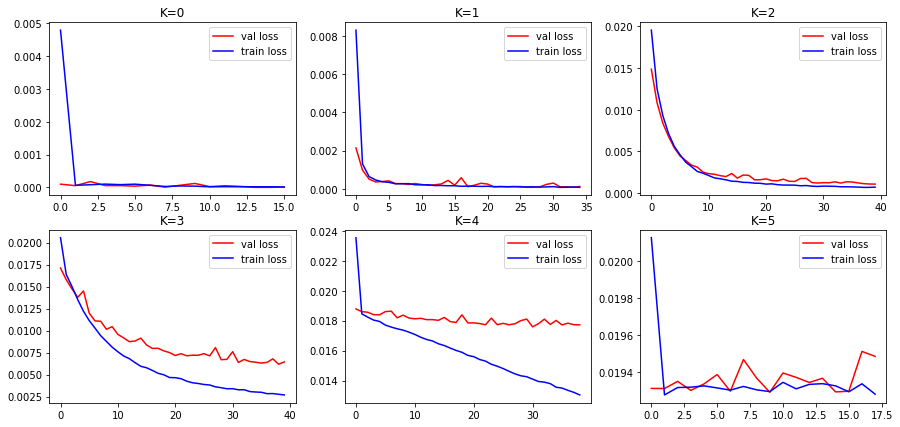

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

for ind, i in enumerate(ax.ravel()):
    i.plot(val_epoch_losses_list[ind], c='r', label='val loss')
    i.plot(train_epoch_losses_list[ind], c='b', label='train loss')
    i.legend()
    i.set_title('K={}'.format(ind))



In [40]:
r2_scores

[0.9996313854901864,
 0.9964798900165509,
 0.9490908192917743,
 0.568154893067858,
 -6.706080842663096,
 -5537960466172.693]

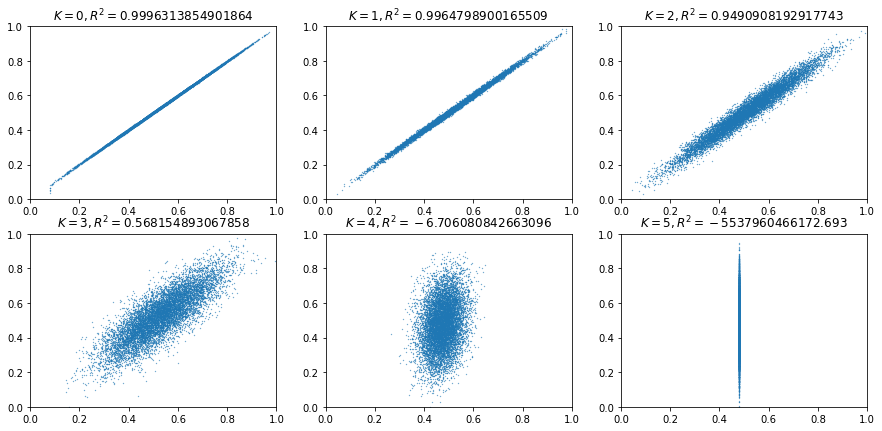

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

for ind, i in enumerate(ax.ravel()):
    i.scatter(predict_vs_gt[ind][0], predict_vs_gt[ind][1],marker='.', s=.3 )
    i.set_ylim(0,1)
    i.set_xlim(0,1)
    i.set_title('$K={0}, R^2={1}$'.format(ind, r2_scores[ind]))